# Bank Churn with Gradient Boosted Decision Trees
In this experiment, we try to predict which customers are most likely to churn using common gradient boosting decision trees.

In [ ]:
# Import necessary libraries
import os

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import plotly.express as px
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

DATA = os.path.join(os.getcwd(), 'data')

c:\Users\Dave\Documents\Experiments\churn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us look at the data that we will use for the experiment. This dataset is taken from [Kaggle](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling).

In [2]:
df = pd.read_csv(os.path.join(DATA, 'Bank_Churn_Modelling.csv')).drop(columns=['RowNumber'])
df.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory Data Analysis
Before we proceed with the modeling, let us explore first the data that we are dealing with.

### Histogram
We generate this histogram to learn more about how each feature is distributed. For our EDA, we deliberately excluded *CustomerID* and *Surname* from our feature set as these are information that obviously should not affect the probability of a customer from churning.

As we can see, features such as *Age* and *CreditScore* have uneven distributions across bins, while features such as *EstimatedSalary* and *Balance* are relatively more even. To know more about this features, let us look at if there are bins that seem to have more customers churning. 

Although looking at the churn rate of all identified features, it may not be ideal for datasets with larger feature sets since it is time-consuming. Other EDA techniques such as using correlation matrices may be helpful in exploring your features

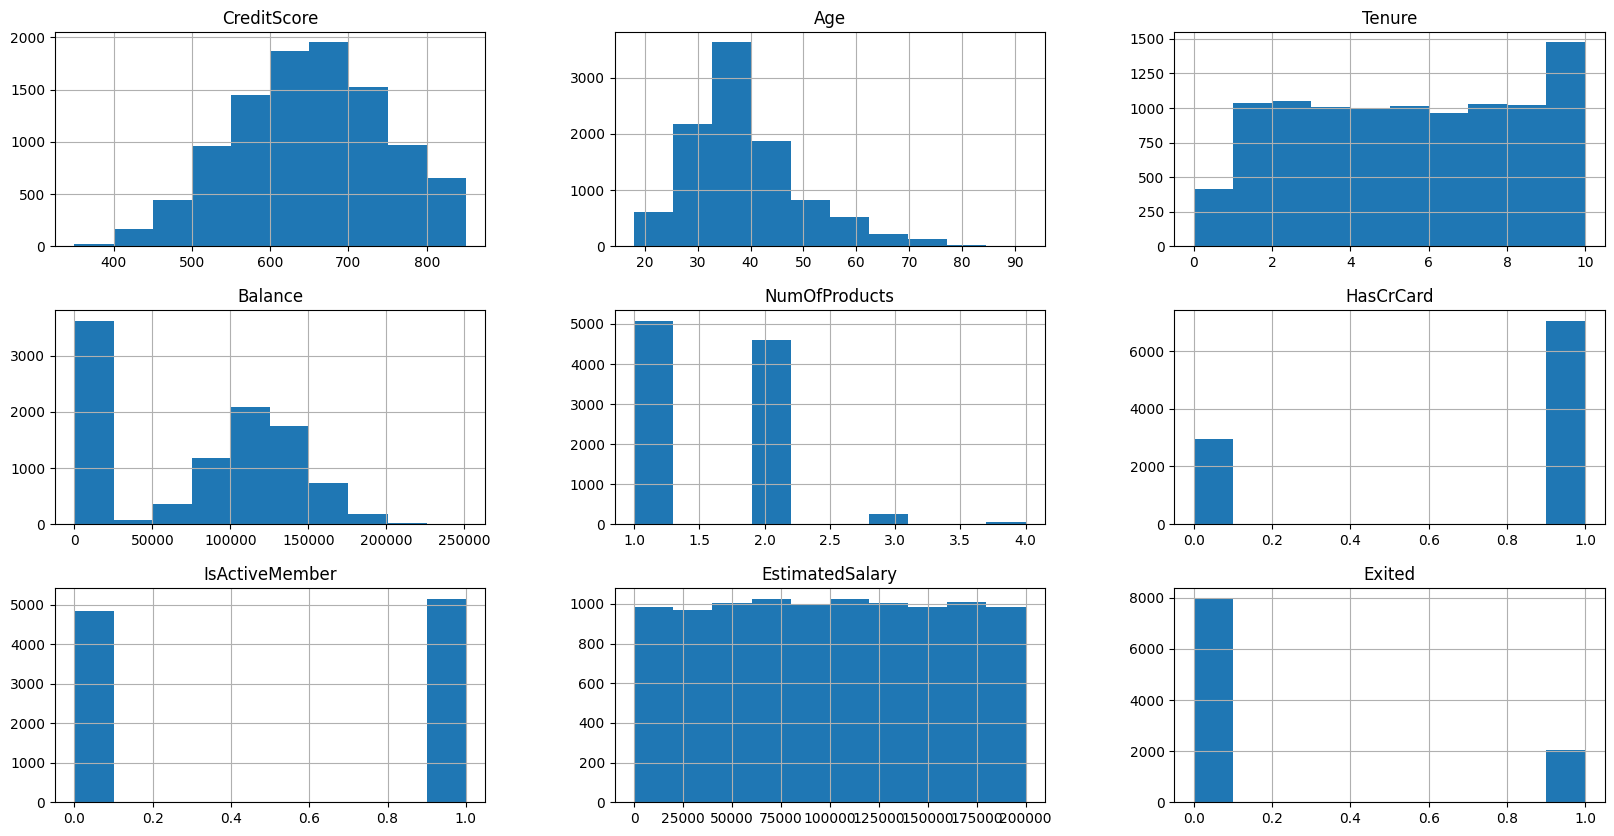

In [3]:
plot = df.hist(column=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'], figsize=(20, 10))

### Churn by Credit Score
Let us first look at the credit score. We divide our data into 10 bins and look at what a customer's credit score may tell us about their probability of churning. From observation, it seems that customers with credit scores from the \[350, 400\), \[600, 650\), and \[650, 700\) range have a higher tendency of customers churning.

In [4]:
fig = px.bar(pd.DataFrame({'Credit Score Bracket': [f'{bin.left} to {bin.right}' for bin in df.groupby(pd.cut(df['CreditScore'], bins=10, right=False), observed=True).size().index.to_list()],
                    'Did not churn': df.groupby(pd.cut(df['CreditScore'], bins=10), observed=True).size() - df.groupby(pd.cut(df['CreditScore'], bins=10), observed=True).sum()['Exited'],
                    'Churned': df.groupby(pd.cut(df['CreditScore'], bins=10), observed=True).sum()['Exited']}), 
             x='Credit Score Bracket',
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Credit Score')
fig.show()

### Churn by Geography
Let us know look at the geography of the customer. From visual inspection, we see that customers from Germany seem to be most likely to churn, followed by customers from Spain and France.

In [5]:
fig = px.bar(pd.DataFrame({'Geography': sorted(df['Geography'].unique()),
                    'Did not churn': df.groupby(['Geography']).size() - df.groupby(['Geography']).sum()['Exited'],
                    'Churned': df.groupby(['Geography']).sum()['Exited']}), 
             x='Geography', 
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Geography')
fig.show()

### Churn by Gender
Now, let us look at the gender data. It seems that from the dataset, female customers are a bit more likely to churn than male customers.

In [6]:
fig = px.bar(pd.DataFrame({'Gender': sorted(df['Gender'].unique()),
                    'Did not churn': df.groupby(['Gender']).size() - df.groupby(['Gender']).sum()['Exited'],
                    'Churned': df.groupby(['Gender']).sum()['Exited']}), 
             x='Gender', 
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Gender')
fig.show()

### Churn by Age
Looking at the graph for Age brackets, it seems that customers from mid-30s to mid-50s have a higher chance of churning than customers of other age brackets.

In [7]:
fig = px.bar(pd.DataFrame({'Age': sorted(df['Age'].unique()),
                    'Did not churn': df.groupby(df['Age']).size() - df.groupby(['Age']).sum()['Exited'],
                    'Churned': df.groupby(['Age']).sum()['Exited']}), 
             x='Age',
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Age')
fig.show()

In [8]:
fig = px.bar(pd.DataFrame({'Age Bracket': [f'{bin.left} to {bin.right}' for bin in df.groupby(pd.cut(df['Age'], bins=10, right=False), observed=True).size().index.to_list()],
                    'Did not churn': df.groupby(pd.cut(df['Age'], bins=10), observed=True).size() - df.groupby(pd.cut(df['Age'], bins=10), observed=True).sum()['Exited'],
                    'Churned': df.groupby(pd.cut(df['Age'], bins=10), observed=True).sum()['Exited']}), 
             x='Age Bracket',
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Age')
fig.show()

### Churn by Tenure
With tenure, we observe that the churn rates are pretty balanced across all brackets, with the extremes (0 and 10 year-tenures) having a lower chance of churning.

In [9]:
fig = px.bar(pd.DataFrame({'Tenure': sorted(df['Tenure'].unique()),
                    'Did not churn': df.groupby(['Tenure']).size() - df.groupby(['Tenure']).sum()['Exited'],
                    'Churned': df.groupby(['Tenure']).sum()['Exited']}), 
             x='Tenure', 
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Tenure')
fig.show()

In [10]:
fig = px.bar(pd.DataFrame({'Tenure Bracket': [f'{bin.left} to {bin.right}' for bin in df.groupby(pd.cut(df['Tenure'], bins=5, right=False), observed=True).size().index.to_list()],
                    'Did not churn': df.groupby(pd.cut(df['Tenure'], bins=5), observed=True).size() - df.groupby(pd.cut(df['Tenure'], bins=5), observed=True).sum()['Exited'],
                    'Churned': df.groupby(pd.cut(df['Tenure'], bins=5), observed=True).sum()['Exited']}), 
             x='Tenure Bracket', 
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Tenure')
fig.show()

### Churn by Bank Balance
With bank balances, we see that a larger group of customers in around the 100,000 to the 150,000 bracket is more likely to churn, along with the 200,000+ bracket.

In [11]:
fig = px.bar(pd.DataFrame({'Balance Bracket': [f'{bin.left} to {bin.right}' for bin in df.groupby(pd.cut(df['Balance'], bins=5, right=False), observed=True).size().index.to_list()],
                    'Did not churn': df.groupby(pd.cut(df['Balance'], bins=5), observed=True).size() - df.groupby(pd.cut(df['Balance'], bins=5), observed=True).sum()['Exited'],
                    'Churned': df.groupby(pd.cut(df['Balance'], bins=5), observed=True).sum()['Exited']}), 
             x='Balance Bracket',
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Bank Balance')
fig.show()

### Churn by Number of Products
Looking at the churn rate of customers by the number of products they have, it seems that the sweet spot is at 2 products since the number of customers churning is way less than the other values.

In [12]:
fig = px.bar(pd.DataFrame({'Number of Products': sorted(df['NumOfProducts'].unique()),
                    'Did not churn': df.groupby(['NumOfProducts']).size() - df.groupby(['NumOfProducts']).sum()['Exited'],
                    'Churned': df.groupby(['NumOfProducts']).sum()['Exited']}), 
             x='Number of Products', 
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Number of Products')
fig.show()

### Churn by Credit Card Holder
Observing the churn rate based on if they are a credit card holder, it seems that there is a negligible difference between the two as ratios are similar.

In [13]:
fig = px.bar(pd.DataFrame({'Has Credit Card': sorted(df['HasCrCard'].unique()),
                    'Did not churn': df.groupby(['HasCrCard']).size() - df.groupby(['HasCrCard']).sum()['Exited'],
                    'Churned': df.groupby(['HasCrCard']).sum()['Exited']}), 
             x='Has Credit Card', 
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Credit Card Holder')
fig.show()

### Churn by Active Membership
Looking at the distribution, it seems that customers with no active membership seem more likely to churn than those who are active members.

In [14]:
fig = px.bar(pd.DataFrame({'Is Active Member': sorted(df['IsActiveMember'].unique()),
                    'Did not churn': df.groupby(['IsActiveMember']).size() - df.groupby(['IsActiveMember']).sum()['Exited'],
                    'Churned': df.groupby(['IsActiveMember']).sum()['Exited']}), 
             x='Is Active Member', 
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Active Member')
fig.show()

### Churn by Estimated Salary
Finally, upon looking at the estimated salary of customers, it seems that the chance of churning is pretty even among all salary brackets.

In [15]:
fig = px.bar(pd.DataFrame({'Salary Bracket': [f'{bin.left} to {bin.right}' for bin in df.groupby(pd.cut(df['EstimatedSalary'], bins=5, right=False), observed=True).size().index.to_list()],
                    'Did not churn': df.groupby(pd.cut(df['EstimatedSalary'], bins=5), observed=True).size() - df.groupby(pd.cut(df['EstimatedSalary'], bins=5), observed=True).sum()['Exited'],
                    'Churned': df.groupby(pd.cut(df['EstimatedSalary'], bins=5), observed=True).sum()['Exited']}), 
             x='Salary Bracket',
             y=['Did not churn', 'Churned'], 
             title='Churn distribution by Estimated Salary')
fig.show()

## Modeling
Let us now try to fit different models to our data and see if they are able to predict well if a customer is likely to churn. For starters, let us select all features first in our dataset (we will try excluding some features later) and set *Exited*, meaning if the customer has exited, as our target variable.

In [16]:
features = [
    'CreditScore'
    , 'Geography'
    , 'Gender'
    , 'Age'
    , 'Tenure'
    , 'Balance'
    , 'NumOfProducts'
    , 'HasCrCard'
    , 'IsActiveMember'
    , 'EstimatedSalary'
]

categorical_features = [
    'Geography',
    'Gender',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember'
]

X = df[features]
y = df[['Exited']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

### XGBoost
For our first model, let us try Extreme Gradient Boosting or more commonly known as XGBoost. If you wish to learn more about XGBoost, you may check out its [documentation](https://xgboost.readthedocs.io/en/stable/). We first feed our train set with the XGBoost classifier model.

In [17]:
xgb_model = XGBClassifier(enable_categorical=True)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Looking at the train scores, it seems that the model has fitted our training data well. However, we are more concerned with how the model performs with our unseen test set. It seems that our model still does relatively well at $86\%$.

However, recall scores for exited customers are low at $48\%$. This means that we are more likely to encounter false negatives, where the model predicts a customer will not churn when it will actually churn.

In [18]:
y_pred_train = xgb_model.predict(X_train)
print(f'Train scores:\n{classification_report(y_train, y_pred_train)}')

y_pred = xgb_model.predict(X_test)
print(f'Test scores:\n{classification_report(y_test, y_pred)}')

Train scores:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5547
           1       0.99      0.86      0.92      1453

    accuracy                           0.97      7000
   macro avg       0.97      0.93      0.95      7000
weighted avg       0.97      0.97      0.97      7000

Test scores:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2416
           1       0.70      0.48      0.57       584

    accuracy                           0.86      3000
   macro avg       0.79      0.72      0.74      3000
weighted avg       0.85      0.86      0.85      3000



Looking at the feature importance plot of XGBoost using the [SHAP](https://github.com/shap/shap) library, it seems that *Age* and *NumOfProducts* were the most important features of the model. 

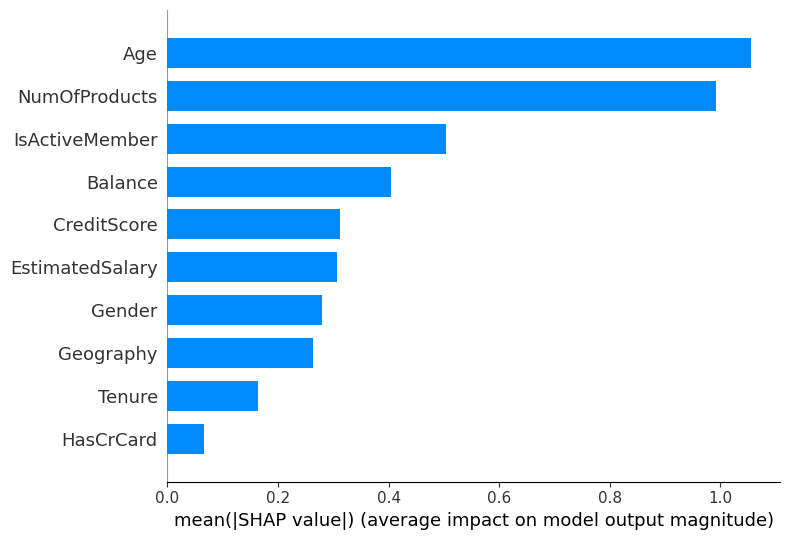

In [19]:
xgb_explainer = shap.Explainer(xgb_model)
xgb_shap_values = xgb_explainer(X_test)
shap.summary_plot(xgb_shap_values, X_test, plot_type='bar')

### CatBoost
Let us now try Categorical Boosting (or CatBoost) as an alternative model, which is said to work better with categorical data. For more information about CatBoost, you may check out their [documentation](https://catboost.ai/). Let us know feed our train data to the CatBoost classifier.

In [20]:
cb_model = CatBoostClassifier(cat_features=categorical_features)
cb_model.fit(X_train, y_train, verbose=False)

Looking at the evaluation scores for CatBoost, it seems that the model performed worse in the train set but was better than XGBoost with predicting unseen test data at $88\%$ accuracy.

However, the problem still seems to be with the recall score for the class of churned customers. Although it improved by a bit, the obtained test recall score is still at $50\%$ thus exposing a high probability of false negatives when predicting customers who will most likely churn.

In [21]:
y_pred_train = cb_model.predict(X_train)
print(f'Train scores:\n{classification_report(y_train, y_pred_train)}')

y_pred = cb_model.predict(X_test)
print(f'Test scores:\n{classification_report(y_test, y_pred)}')

Train scores:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5547
           1       0.88      0.61      0.72      1453

    accuracy                           0.90      7000
   macro avg       0.89      0.79      0.83      7000
weighted avg       0.90      0.90      0.89      7000

Test scores:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2416
           1       0.78      0.50      0.61       584

    accuracy                           0.88      3000
   macro avg       0.83      0.73      0.77      3000
weighted avg       0.87      0.88      0.86      3000



From the feature importance plot, it seems that *NumOfProducts* and *Age* are also the most important features of the model. However, CatBoost gives the slight edge to *NumOfProducts* in terms of importance compared to XGBoost that has *Age* as the most important feature.

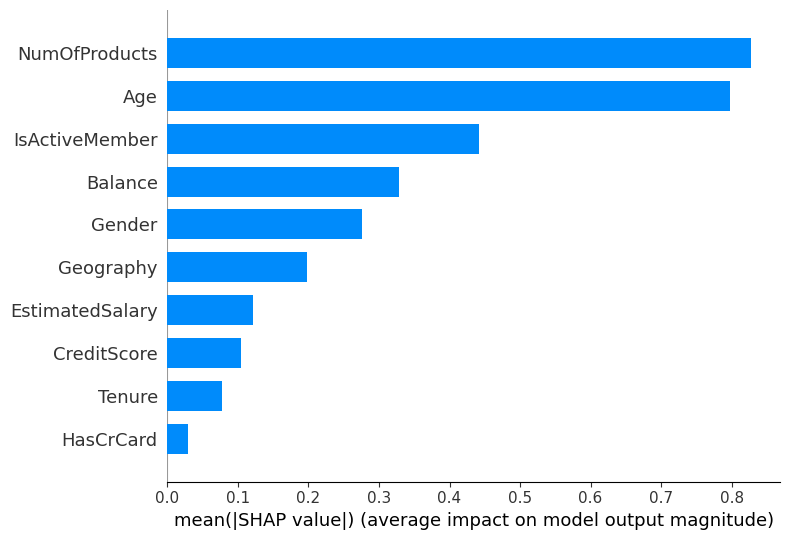

In [22]:
cb_explainer = shap.Explainer(cb_model)
cb_shap_values = cb_explainer(X_test)
shap.summary_plot(cb_shap_values, X_test, plot_type='bar')

### LightGBM
Finally, let us try using Light Gradient-Boosting Machine, also known as LightGBM, as our final gradient boosted tree. For more information about LightGBM, you may check out their official [documentation](https://lightgbm.readthedocs.io/). Now, let us train the LightGBM classifier with our data.

In [23]:
lgbm_model = LGBMClassifier(verbosity=0)
lgbm_model.fit(X_train, np.ravel(y_train))

LGBMClassifier(verbosity=0)

Observing the evaluation scores for LightGBM, it seems to be right in the middle of the pack when it comes to bias-variance tradeoffs. Its train scores are better than CatBoost but worse than XGBoost, while its test scores are better than XGBoost but worse than CatBoost at $87\%$ test accuracy. As expected, the lowest performing score is still the recall for the churned class at $49\%$, showing its vulnerability to falsely predict churning customers as non-churning.

In [24]:
y_pred_train = lgbm_model.predict(X_train)
print(f'Train scores:\n{classification_report(y_train, y_pred_train)}')

y_pred = lgbm_model.predict(X_test)
print(f'Test scores:\n{classification_report(y_test, y_pred)}')

Train scores:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5547
           1       0.91      0.68      0.78      1453

    accuracy                           0.92      7000
   macro avg       0.92      0.83      0.87      7000
weighted avg       0.92      0.92      0.92      7000

Test scores:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.74      0.49      0.59       584

    accuracy                           0.87      3000
   macro avg       0.81      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



The feature importance plot of LightGBM seems to be a bit similar with XGBoost, having *Age* as the most important feature with *NumOfProducts* following closely.

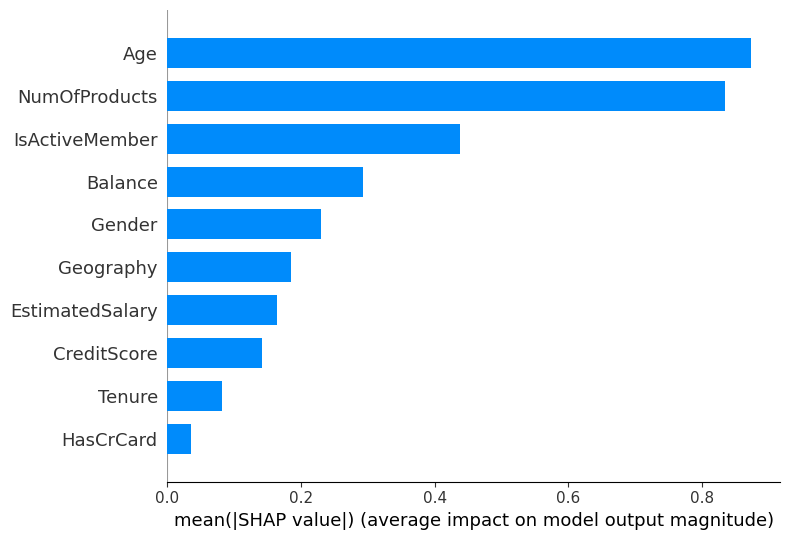

In [25]:
lgbm_explainer = shap.Explainer(lgbm_model)
lgbm_shap_values = lgbm_explainer(X_test)
shap.summary_plot(lgbm_shap_values, X_test, plot_type='bar')

## Conclusion
Although we managed to have good accuracy scores for all three GBDTs (with $>85\%$ accuracy), there are still concerns on how effective are model is in terms of preventing customers from churning. Personally, having a good recall score seems to be more ideal than a high precision score because we want to identify which customers are actually likely to churn, in order to prevent them from doing so. If we have too many false negatives from our model, then we would fail to identify which customers we actually need to focus our retention efforts into.

## Extra experiment: Removing features
As an extra experiment, let us try to remove features and see how they affect model performance. Specifically, let us try and remove the *HasCrCard* and *EstimatedSalary* features as they seem to have the most even distributions, which may not be helpful for our boosted trees when splitting the data.

In [26]:
features = [
    'CreditScore'
    , 'Geography'
    , 'Gender'
    , 'Age'
    , 'Tenure'
    , 'Balance'
    , 'NumOfProducts'
    # , 'HasCrCard'
    , 'IsActiveMember'
    # , 'EstimatedSalary'
]

categorical_features = [
    'Geography',
    'Gender',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember'
]

categorical_features = [feature for feature in categorical_features if feature in features]

X = df[features]
y = df[['Exited']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

For this section, we will use LightGBM as our model.

In [27]:
lgbm_model = LGBMClassifier(verbosity=0)
lgbm_model.fit(X_train, np.ravel(y_train))

LGBMClassifier(verbosity=0)

Looking at the evaluation scores, the model has taken a small dip in train accuracy (from $92\%$ to $91\%$). However, one noticeable difference is the model's improvement in test recall scores. Although still low, its recall score on the churned/exited class jumped from $49\%$ to $52\%$.

In [28]:
y_pred_train = lgbm_model.predict(X_train)
print(f'Train scores:\n{classification_report(y_train, y_pred_train)}')

y_pred = lgbm_model.predict(X_test)
print(f'Test scores:\n{classification_report(y_test, y_pred)}')

Train scores:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5547
           1       0.89      0.65      0.75      1453

    accuracy                           0.91      7000
   macro avg       0.90      0.81      0.85      7000
weighted avg       0.91      0.91      0.91      7000

Test scores:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2416
           1       0.74      0.52      0.61       584

    accuracy                           0.87      3000
   macro avg       0.82      0.74      0.77      3000
weighted avg       0.86      0.87      0.86      3000

